In [1]:
# Import your favourite library
import pennylane as qml

# Import Numpy from PennyLane
from pennylane import numpy as np

# Import the library that you need in order to use your IBM account
# import qiskit_ibm_provider

# IBM_token = #'Your Token Goes Here'

# try:
#     qiskit_ibm_provider.IBMProvider()
# except:
#     qiskit_ibm_provider.IBMProvider.save_account(token=IBM_token, overwrite=True)

In [8]:
arr = [0.019466712003046782, 0.02751842868380805, 0.018593599298792507, 0.026775438625708747, 0.008555715005087727, 0.01906222243811989, 0.035645359669159715, 0.02402423046572605, 0.02387470677644382, 0.021377683154572946, 0.016215876387670358, 0.022385726477138046, 0.03090332411723118, 0.019775650530536648, 0.015155925931429559, 0.028059251640292715, 0.027177337324130635, 0.0174309122705657, 0.013136832746213689, 0.017597735959724692]

In [9]:
abs(np.mean(arr[:10]) - np.mean(arr[10:]))

0.0017055522735533006

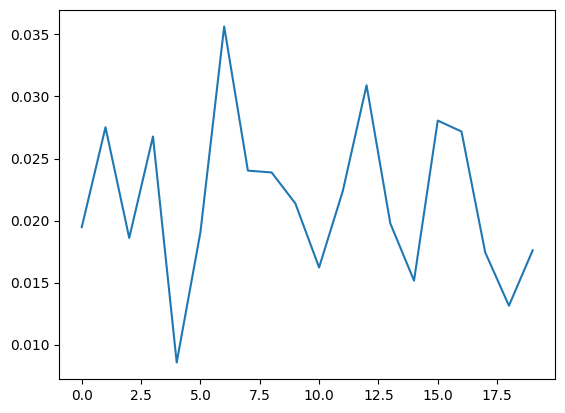

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(20), arr)
plt.show()

sample [[0 1]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 0]
 [1 1]]


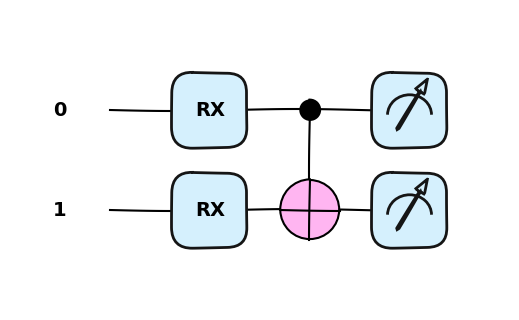

In [2]:
# Choose the device you want to use.
# dev = qml.device("lightning.qubit", wires=2, shots=1000)
dev = qml.device('qiskit.aer', wires=2, shots=1000)
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibmq_qasm_simulator')
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibm_lagos')


# Create a QNode with 2 entangled qubits
@qml.qnode(dev)
def circuit(theta):
    qml.RX(theta[0],wires=0)
    qml.RX(theta[1],wires=1)
    qml.CNOT(wires=[0,1])
    # return qml.expval(qml.PauliZ(wires=range(0,1)))
    return qml.sample()

thetas = np.array([[1.0,2.0],[1.0,2.0]],requires_grad=True)
# Draw your circuit
qml.draw_mpl(circuit,style='pennylane')(thetas)

# Run your circuit
print('sample', np.concatenate(circuit(thetas), axis=0))
# print('sample', circuit(thetas))

In [3]:
def cost(circuit, thetas):
    c = circuit(thetas)
    return np.mean(c)

In [4]:
cost(circuit, thetas)

0.42425

In [5]:
opt = qml.GradientDescentOptimizer(0.01)

In [6]:
cost_history = []
for it in range(10):
# for it in range(steps):
    thetas, prev_cost = opt.step_and_cost(lambda thetas: cost(circuit, thetas), thetas)
    
    # clear_output(wait=True)

    print("Step {:3d}       Cost_L = {:9.7f}".format(it, prev_cost), flush=True)
    cost_history.append(prev_cost)

ValueError: shape-mismatch for sum

In [6]:
n_qubits = 3
ancilla_idx = 3

In [7]:
dev = qml.device("lightning.qubit", wires=n_qubits*2, shots=1000)

In [8]:
from problems.toy_problem import *
problem = ToyProblem(
    n_qubits=n_qubits,
)

In [9]:
@qml.qnode(dev)
def hadamard_overlap_test(weights, problem, l=None, lp=None, part=None):
    """implements the overlap test for C_G"""

    n_qubits = problem.get_n_qubits()
    ancilla_idx = n_qubits * 2

    # H on ancilla index
    qml.Hadamard(ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x> applied to the top half
    problem.variational_block(weights, offset=n_qubits)

    # unitary U_b associated to the problem vector |b> applied to the bottom half
    # In this specific example Adjoint(U_b) = U_b.
    problem.U_b()

    # Controlled application of the unitary component A_l of the problem matrix A on the top half.
    problem.CA(ancilla_idx, l, offset=n_qubits)

    # Controlled application of Adjoint(A_lp) applied to the bottom half
    # In this specific example Adjoint(A_lp) = A_lp. #TODO: is it really?
    problem.CA(ancilla_idx, lp)

    if part == "Im":
        qml.RZ(phi=-np.pi/2, wires=ancilla_idx)

    # bell basis observable
    [qml.CNOT(wires=(i+n_qubits, i)) for i in range(n_qubits)]
    [qml.Hadamard(wires=i) for i in range(n_qubits, n_qubits*2 + 1)]

    # to get P(0) - P(1) we need to perform linear classical post-processing which involves using the probabilities
    return qml.probs(wires=range(n_qubits*2 + 1))

In [10]:
w = 0.001 * np.random.randn(problem.param_shape, requires_grad=True)

qml.draw_mpl(hadamard_overlap_test,style='pennylane')(w, 1, 1, "Re")

AttributeError: 'int' object has no attribute 'get_n_qubits'

In [1]:
def get_bin(bitstring: str):
    """
    @param
    bitstring: a measurement outcome as a bitstring
    return: (-1 or 1, corresponding to whether the prob on the bitstring should be added or subtracted)
    """
    acc = 1

    n_qubits = (len(bitstring) - 1) // 2

    if bitstring[-1] == "1":
        acc *= -1

    for i in range(n_qubits):
        if bitstring[i] == bitstring[i+n_qubits] == "1":
            acc *= -1

    return acc

In [11]:
def get_bin_int(state: int, n_qubits):
    """
    @param
    state: a measurement outcome as an int 
    return: (-1 or 1, corresponding to whether the prob on the bitstring should be added or subtracted)
    """
    acc = 1

    # if aux qubit is 1
    if state & 2**(n_qubits*2):
        acc *= -1

    for i in range(n_qubits):
        if state & 2**i and state & 2**(i + n_qubits):
            acc *= -1

    return acc

In [9]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    # return qml.expval(qml.PauliZ(wires=range(0,1)))
    return qml.probs(wires=range(2))

In [10]:
circuit()

tensor([0., 0., 1., 0.], requires_grad=True)